# **Práctica 10: Archivos.**

## **Librerías**

In [787]:
import os
import json
import random
import string
from datetime import datetime
import matplotlib.pyplot as plt

## **Clases de Modelos**

In [788]:
class User:
    def __init__(self, user_id, name, password):
        self.id = user_id
        self.name = name
        self.password = password
    
    def __str__(self):
        return f"User(ID={self.id}, Nombre={self.name})"

class File:
    def __init__(self, file_id, name, id_owner, name_owner, content=""):
        self.key = file_id
        self.name = name
        self.id_owner = id_owner
        self.name_owner = name_owner
        self.content = content
    
    def __str__(self):
        return f"Información del archivo:\nID: {self.key},\nNombre: {self.name},\nPropietario: {self.name_owner}"

class Session:
    def __init__(self, user_id, isValid=True):
        self.user_id = user_id
        self.datetime = datetime.now()
        self.isValid = isValid
    
    def __str__(self):
        return f"Session(UserID={self.user_id}, Fecha={self.datetime}, Válido={self.isValid})"
    
class IndexEntry:
    def __init__(self, file_name, primary_id):
        self.key = file_name 
        self.value = primary_id

## **Árbol B**

In [789]:
class Data:
    def __init__(self, key, value):
        self.key = key
        self.value = value

    def __str__(self):
        return str(self.key) + "->" + self.value

class BTreeNode:
    def __init__(self, t, leaf):
        self.t = t
        self.keys = [None] * (2 * t - 1)
        self.C = [None] * (2 * t)
        self.n = 0
        self.leaf = leaf

    def insertNonFull(self, data):
        i = self.n - 1
        if self.leaf:
            while i >= 0 and self.keys[i].key > data.key:
                self.keys[i + 1] = self.keys[i]
                i -= 1
            self.keys[i + 1] = data
            self.n += 1
        else:
            while i >= 0 and self.keys[i].key > data.key:
                i -= 1
            if self.C[i + 1].n == 2 * self.t - 1:
                self.splitChild(i + 1, self.C[i + 1])
                if self.keys[i + 1].key < data.key:
                    i += 1
            self.C[i + 1].insertNonFull(data)

    def splitChild(self, i, y):
        z = BTreeNode(y.t, y.leaf)
        z.n = self.t - 1
        for j in range(self.t - 1):
            z.keys[j] = y.keys[j + self.t]
        if not y.leaf:
            for j in range(self.t):
                z.C[j] = y.C[j + self.t]
        y.n = self.t - 1
        for j in range(self.n, i, -1):
            self.C[j + 1] = self.C[j]
        self.C[i + 1] = z
        for j in range(self.n - 1, i - 1, -1):
            self.keys[j + 1] = self.keys[j]
        self.keys[i] = y.keys[self.t - 1]
        self.n += 1

    def traverse(self, l):
        for i in range(self.n):
            if not self.leaf:
                self.C[i].traverse(l + 1)
            print("\t" * l, l, self.keys[i], end=' ')
        print()
        if not self.leaf:
            # Corregido: El PDF decía self.C[i + 1], lo cual es un error.
            # Debe ser el último hijo, self.C[self.n].
            self.C[self.n].traverse(l + 1)

    def search(self, k):
        i = 0
        while i < self.n and k > self.keys[i].key:
            i += 1
        if i < self.n and k == self.keys[i].key:
            return self.keys[i]
        if self.leaf:
            return None
        return self.C[i].search(k)

class BTree:
    def __init__(self, t):
        self.root = None
        self.t = t

    def traverse(self):
        if self.root != None:
            self.root.traverse(0)

    def search(self, k):
        return None if self.root == None else self.root.search(k)

    def insert(self, data):
        if self.root == None:
            self.root = BTreeNode(self.t, True)
            self.root.keys[0] = data
            self.root.n = 1
        else:
            if self.root.n == 2 * self.t - 1:
                s = BTreeNode(self.t, False)
                s.C[0] = self.root
                s.splitChild(0, self.root)
                i = 0
                if s.keys[0].key < data.key:
                    i += 1
                s.C[i].insertNonFull(data)
                self.root = s
            else:
                self.root.insertNonFull(data)


## **Funciones para Gestionar los JSON**

In [790]:
class JsonController:
    def __init__(self):
        self.files_tree = BTree(2)
        self.name_index = BTree(2)
        self.sessions = []
        self.file_counters = {}
        self.permits = {}
        self._cargar_sesiones()
        self.cargar_archivos_desde_json()
        self.cargar_permisos()
        self._guardar_sesiones_json()

    def _cargar_sesiones(self):
        """Carga sesiones existentes desde sessions.json al iniciar el sistema."""
        try:
            if os.path.exists("sessions.json"):
                with open("sessions.json", "r", encoding="utf-8") as file:
                    sessions_data = json.load(file)
                    for session_data in sessions_data:
                        # Reconstruir el objeto Session
                        session = Session(
                            session_data["user_id"],
                            session_data["isValid"]
                        )
                        # Restaurar el datetime, que JSON guarda como string
                        session.datetime = datetime.fromisoformat(session_data["datetime"])
                        self.sessions.append(session)
        except Exception as e:
            # Esto puede ocurrir si el archivo está vacío o mal formado, no es un error crítico
            print(f"Error al cargar sesiones: {e}")

    def cargar_archivos_desde_json(self): # FINISHED
        try:
            if os.path.exists("files.json"):
                with open("files.json", "r", encoding="utf-8") as file:
                    files_data = json.load(file)
                    for file_data in files_data:
                        nuevo_archivo = File(file_data["id"], file_data["name"], file_data["id_owner"], file_data["name_owner"], file_data["content"])
                        self.files_tree.insert(nuevo_archivo)
                        index_entry = IndexEntry(nuevo_archivo.name, nuevo_archivo.key)
                        self.name_index.insert(index_entry)
                print("Se cargaron correctamente los archivos")
        except Exception as e:
            print(f"Error al cargar archivos: {e}")

    def cargar_permisos(self): # FINISHED
        try:
            if os.path.exists("permits.json"):
                with open("permits.json", "r", encoding="utf-8") as file:
                    permits_data = json.load(file)
                    for user_entry in permits_data:
                        user_id = user_entry["id_user"]
                        permisos = {int(k): v for k, v in user_entry.items() if k != "id_user"}
                        self.permits[user_id] = permisos
                print("Se cargaron correctamente los permisos")
        except Exception as e:
            print(f"Error al cargar permisos: {e}")

    def verificar_usuario(self, user_id, password): # FINISHED
        try:
            if not os.path.exists("users.json"):
                print("Error: Archivo users.json no encontrado")
                return None
            
            with open("users.json", "r", encoding="utf-8") as file:
                users_data = json.load(file)
            
            for user_data in users_data:
                if str(user_data.get("id")) == user_id and user_data.get("password") == password:
                    return User(user_id, user_data["name"], password)
            
            return None
            
        except Exception as e:
            print(f"Error al leer users.json: {e}")
            return None
    
    def guardar_sesion(self, session): # FINISHED
        """Guardar los registros de session"""
        self.sessions.append(session)
        self._guardar_sesiones_json()
    
    def _guardar_sesiones_json(self):
        """Guardar sesiones en sessions.json"""
        try:
            sessions_data = []
            for session in self.sessions:
                session_data = {
                    "user_id": session.user_id,  # Cambiado de ID_del_user
                    "datetime": session.datetime.isoformat(),  # Cambiado de Fecha_y_Hora
                    "isValid": session.isValid  # Cambiado de Ingreso_Válido
                }
                sessions_data.append(session_data)
            
            with open("sessions.json", "w", encoding="utf-8") as file:
                json.dump(sessions_data, file, indent=2)
        except Exception as e:
            print(f"Error al guardar sesiones: {e}")

    def buscar_archivo_por_nombre(self, file_name): # FINISHED
        index_entry = self.name_index.search(file_name) 
        if index_entry:
            file_id = index_entry.value
            # El search del files_tree busca un objeto File usando el ID (int)
            return self.files_tree.search(file_id)
        else: return None
    
    def _recopilar_archivos(self, node, archivos_list, exclude_id=None): # FINISHED
        """Recopilar todos los archivos del árbol B"""
        if node is None:
            return
        
        for i in range(node.n):
            if not node.leaf:
                self._recopilar_archivos(node.C[i], archivos_list, exclude_id)
            
            # CORRECCIÓN CLAVE: node.keys[i] ES el objeto File.
            archivo = node.keys[i] 
            
            # Usamos archivo.key para la comparación (el ID del archivo)
            if exclude_id is None or archivo.key != exclude_id: 
                archivos_list.append(archivo)
        
        if not node.leaf:
            self._recopilar_archivos(node.C[node.n], archivos_list, exclude_id)

    def obtener_archivos_permitidos(self, user_id): # FINISHED
        """Obtiene una lista de IDs de archivos a los que el usuario tiene acceso por permisos explícitos."""
        archivos_permitidos_ids = set()
        user_permits = self.permits.get(user_id)
        
        if user_permits:
            # Iterar sobre cada nivel de acceso permitido (1 a 9)
            for level_access, file_ids in user_permits.items():
                for file_id in file_ids:
                    # Convertir el ID de archivo a entero
                    archivos_permitidos_ids.add(int(file_id)) 
        
        return list(archivos_permitidos_ids)
    
    def generar_file_id(self):
        """Genera un ID de archivo único (el ID más alto + 1)."""
        max_id = 0
        archivos_list = []
        
        # Recopilar todos los archivos del Árbol B para encontrar el ID más alto.
        self._recopilar_archivos(self.files_tree.root, archivos_list)
        
        for archivo in archivos_list:
            if archivo.key > max_id:
                max_id = archivo.key
        
        return max_id + 1

    def guardar_archivo(self, file):
        """Guardar archivo en el árbol B, el índice secundario y actualizar files.json."""
        # Se inserta el objeto File directamente en el Árbol B principal.
        self.files_tree.insert(file)
        
        # Se actualiza el índice de nombres (Árbol B secundario).
        index_entry = IndexEntry(file.name, file.key)
        self.name_index.insert(index_entry)

        self._actualizar_files_json()

    def asignar_permiso(self, user_id, file_id, level):
        """Asigna un nivel de permiso (Nivel 1-9) a un archivo, asegurando que solo haya uno por archivo/usuario."""
        user_id_str = str(user_id)
        file_id_int = int(file_id)
        
        if user_id_str not in self.permits:
            self.permits[user_id_str] = {}
        
        # 1. Eliminar el file_id de CUALQUIER otro nivel del usuario (asegurando permiso único)
        # Recorremos todos los niveles posibles (1 a 9)
        for existing_level in range(1, 10):
            # Solo si el nivel existente es diferente del nivel que vamos a asignar
            if existing_level != level and existing_level in self.permits[user_id_str]:
                if file_id_int in self.permits[user_id_str][existing_level]:
                    self.permits[user_id_str][existing_level].remove(file_id_int)
                    
        # 2. Asignar o actualizar el permiso
        if level not in self.permits[user_id_str]:
            self.permits[user_id_str][level] = []
        
        # Prevenir duplicados si ya está en la lista del nivel correcto
        if file_id_int not in self.permits[user_id_str][level]:
            self.permits[user_id_str][level].append(file_id_int)
        
        # 3. Guardar los permisos actualizados en permits.json
        self._actualizar_permits_json()

# --- Nuevas Funciones Auxiliares ---
    
    # Se añade la función _actualizar_files_json (previamente no definida en el código):
    def _actualizar_files_json(self):
        """Actualizar files.json con todos los archivos del árbol B (necesario al crear/modificar)"""
        try:
            archivos_list = []
            self._recopilar_archivos(self.files_tree.root, archivos_list)
            
            files_data = []
            for archivo in archivos_list:
                file_data = {
                    "id": int(archivo.key),
                    "id_owner": archivo.id_owner, 
                    "name_owner": archivo.name_owner,
                    "name": archivo.name,
                    "content": archivo.content
                }
                files_data.append(file_data)
            
            with open("files.json", "w", encoding="utf-8") as file:
                json.dump(files_data, file, indent=2)
                
            print("Archivo files.json actualizado.")
            
        except Exception as e:
            print(f"Error al actualizar files.json: {e}")

    # Se añade la función _actualizar_permits_json (necesaria para asignar_permiso):
    def _actualizar_permits_json(self):
        """Guardar los permisos actualizados en permits.json."""
        try:
            permits_data = []
            
            # Convertir el diccionario self.permits de vuelta al formato de lista para JSON
            for user_id, permisos in self.permits.items():
                user_entry = {"id_user": user_id}
                for level, file_ids in permisos.items():
                    user_entry[str(level)] = file_ids
                permits_data.append(user_entry)
            
            with open("permits.json", "w", encoding="utf-8") as file:
                json.dump(permits_data, file, indent=4)
            
            print("Archivo permits.json actualizado.")
            
        except Exception as e:
            print(f"Error al guardar permits.json: {e}")

    def contar_intentos_sesion(self):
        """Cuenta los intentos de sesión (válidos/inválidos) por usuario."""
        conteo = {}
        for session in self.sessions:
            user_id = session.user_id
            if user_id not in conteo:
                conteo[user_id] = {'validos': 0, 'invalidos': 0}
            
            if session.isValid:
                conteo[user_id]['validos'] += 1
            else:
                conteo[user_id]['invalidos'] += 1
        return conteo
    
    def contar_niveles_acceso(self, user_id):
        """Cuenta la cantidad de archivos para cada nivel de acceso de un usuario específico."""
        user_permits = self.permits.get(user_id)
        if not user_permits:
            return {}
        
        conteo_niveles = {}
        for level, file_ids in user_permits.items():
            # El conteo es simplemente el número de archivos en esa lista de IDs
            conteo_niveles[level] = len(file_ids)
            
        return conteo_niveles

## **Funciones para Graficar**

## **Clase Principal**

In [791]:
class FileSystem:
    def __init__(self):
        self.json_controller = JsonController()
        self.current_user = None
        self.current_session = None
    
    def iniciar_sesion(self, user_id, password): # FINISHED
        usuario = self.json_controller.verificar_usuario(user_id, password)
        if usuario:
            self.current_user = usuario
            self.current_session = Session(user_id, True)
            self.json_controller.guardar_sesion(self.current_session)
            print(f"¡Bienvenid@ {usuario.name}!")
            return True
        else:
            session_fallida = Session(user_id, False)
            self.json_controller.guardar_sesion(session_fallida)
            print("Error: ID de usuario o contraseña incorrectos")
            return False
    
    def cerrar_sesion(self): # FINISHED
        """Cerrar Sesión"""
        if self.current_user:
            print(f"Sesión cerrada para {self.current_user.name}")  # Cambiado de Nombre a name
            self.current_user = None
            self.current_session = None
        else:
            print("No hay sesión activa")

    def buscar_abrir_archivo(self, file_name):
        if not self.current_user:
            print("Error: Debe iniciar sesión primero para buscar archivos.")
            return

        # 1. Buscar el archivo por nombre
        archivo = self.json_controller.buscar_archivo_por_nombre(file_name)

        if not archivo:
            print(f"Error: El archivo '{file_name}' no existe o no se encontró.")
            return

        user_id = self.current_user.id
        highest_level = self._get_file_access_level(user_id, archivo.key)
        
        if highest_level is None: highest_level = 0

        # 3. Aplicar la regla de visibilidad: Nivel > 1
        if highest_level < 2:
            print(f"No tienes el nivel de acceso suficiente para visualizar el archivo '{file_name}'.")
            return
            
        # Si llegamos aquí, el usuario tiene permiso para visualizar (highest_level >= 2)
        print(f"\n--- Información y Permisos para el archivo: '{archivo.name}' (ID: {archivo.key}) ---")
        print(f"Propietario: {archivo.name_owner}")
        
        print("\nAcciones que puedes realizar:")
        if highest_level == 2: print("- Puedes saber quien es el propietario (Conocimiento)")
        if highest_level == 3: print("- Puedes ejecutarlo (Ejecución)")
        if highest_level == 4: print("- Puedes leerlo (Lectura)")
        if highest_level == 5: print("- Puedes modificarlo (Escritura)")
        if highest_level == 6: print("- Puedes agregar contenido pero no eliminar o modificar (Agregar)")
        if highest_level == 7: print("- Puedes modificar, borrar  agregar contenido (Actualizar)")
        if highest_level == 8: print("- Puedes ver quienes tienen pemisos sobre el archivo y modificarlos (Modificar Permisos)")
        if highest_level == 9: print("- Puedes borrar el archivo (Borrar)")
    
    def listar_archivos_accesibles(self):
        """
        Lista solo el ID y el Nombre de los archivos accesibles
        por permiso (Nivel >= 2, según permits.json).
        """
        if not self.current_user:
            print("Error: Debe iniciar sesión primero")
            return

        # 1. Preparar el mapa de archivos accesibles
        archivos_accesibles_map = {}
        user_id = self.current_user.id
        archivos_permitidos_ids = self.json_controller.obtener_archivos_permitidos(user_id)
        
        # 2. Recopilar todos los archivos del sistema
        archivos_list = []
        self.json_controller._recopilar_archivos(self.json_controller.files_tree.root, archivos_list)
        archivos_completos = {archivo.key: archivo for archivo in archivos_list}

        # 3. Filtrar y procesar los archivos
        for file_id in archivos_permitidos_ids:
            archivo = archivos_completos.get(file_id)
            
            if archivo:
                # Obtener el nivel de acceso (siempre único)
                level_access = self._get_file_access_level(user_id, file_id) 

                # APLICACIÓN DE LA REGLA: Solo visible si el nivel de acceso es 2 o superior
                if level_access >= 2: 
                    # Solo añadimos el archivo una vez
                    if file_id not in archivos_accesibles_map:
                        archivos_accesibles_map[file_id] = {"archivo": archivo}
        
        
        archivos_finales = list(archivos_accesibles_map.values())
        
        if not archivos_finales:
            print("No tienes archivos accesibles en el sistema (Nivel de acceso < 2)")
            return
        
        # 4. Imprimir la lista final con solo ID y Nombre
        print(f"\nArchivos accesibles ({len(archivos_finales)}):")
        for item in archivos_finales:
            archivo = item["archivo"]
            # Muestra solo el ID y el Nombre
            print(f"- Nombre: {archivo.name}")

    def _get_file_access_level(self, user_id, file_id):
        """Determina el nivel de acceso (único) que un usuario tiene para un archivo específico (0 si no tiene permiso)."""
        user_permits = self.json_controller.permits.get(user_id, {})
        
        # Buscar en todos los niveles (1 a 9)
        for level, file_ids in user_permits.items():
            # file_id debe coincidir con los IDs almacenados en permits.json
            if file_id in file_ids:
                return level # Devuelve el nivel tan pronto como lo encuentra
        
        return 0 # Nivel 0 si no se encuentra permiso
    
    def crear_archivo(self, file_name, content="", permissions=None):
        """
        Crea un nuevo archivo, lo guarda y asigna permisos basados en el diccionario proporcionado.
        
        permissions debe ser un diccionario en el formato: 
        { "id_usuario": nivel_acceso, ... }
        """
        if not self.current_user:
            print("Error: Debe iniciar sesión para crear un archivo.")
            return

        user_id = self.current_user.id
        user_name = self.current_user.name
        
        # 1. Verificación de la regla de negocio: El creador DEBE asignarse Nivel 9
        CREATOR_ACCESS_LEVEL = 9
        if not permissions or str(user_id) not in permissions or permissions[str(user_id)] != CREATOR_ACCESS_LEVEL:
            print(f"Error: Como creador, debes asignarte el permiso Nivel {CREATOR_ACCESS_LEVEL} (Acceso Total) en el diccionario de permisos.")
            return
            
        # 2. Generar ID y crear objeto File
        new_file_id = self.json_controller.generar_file_id()
        new_file = File(new_file_id, file_name, user_id, user_name, content)
        
        # 3. Guardar archivo en BTree y files.json
        self.json_controller.guardar_archivo(new_file)
        
        # 4. Asignar todos los permisos proporcionados
        print(f"\nArchivo '{file_name}' (ID: {new_file_id}) creado exitosamente.")
        print("Asignando permisos...")
        
        for target_user_id, access_level in permissions.items():
            target_user_id_str = str(target_user_id)
            
            # Validación simple del nivel
            if 1 <= access_level <= 9:
                self.json_controller.asignar_permiso(target_user_id_str, new_file_id, access_level)
                print(f" -> Permiso Nivel {access_level} asignado al Usuario ID: {target_user_id_str}.")
            else:
                print(f" -> Advertencia: Nivel de acceso {access_level} inválido para el Usuario ID: {target_user_id_str}. Ignorado.")

    def graficar_intentos_sesion(self, user_id=None):
        """
        Genera una gráfica de barras de intentos de sesión (válidos/inválidos).
        Si user_id es None, grafica para todos los usuarios.
        """
        conteo = self.json_controller.contar_intentos_sesion()
        
        if not conteo:
            print("No hay datos de sesiones para graficar.")
            return

        if user_id:
            if user_id in conteo:
                # Filtrar solo el usuario específico
                data_to_plot = {user_id: conteo[user_id]}
                title = f'Intentos de Sesión (Válidos vs. Inválidos) para Usuario {user_id}'
                file_name = f'intentos_sesion_user_{user_id}.png'
            else:
                print(f"No hay datos de sesiones para el usuario {user_id}.")
                return
        else:
            # Graficar todos los usuarios
            data_to_plot = conteo
            title = 'Intentos de Sesión (Válidos vs. Inválidos) por Usuario (Todos)'
            file_name = 'intentos_sesion_todos.png'
            
        # Preparar los datos para la gráfica
        users = list(data_to_plot.keys())
        validos = [data['validos'] for data in data_to_plot.values()]
        invalidos = [data['invalidos'] for data in data_to_plot.values()]
        
        x = range(len(users))
        width = 0.35
        
        # Ajustar el tamaño de la figura para que las etiquetas sean legibles
        plt.figure(figsize=(max(8, len(users) * 0.8), 6))
        
        # Barras Válidos
        plt.bar([i - width/2 for i in x], validos, width, label='Válidos', color='green')
        
        # Barras Inválidos
        plt.bar([i + width/2 for i in x], invalidos, width, label='Inválidos', color='red')
        
        # Etiquetas y título
        plt.xlabel('Usuario ID')
        plt.ylabel('Número de Intentos')
        plt.title(title)
        plt.xticks(x, users, rotation=45, ha='right')
        plt.legend()
        plt.tight_layout()
        
        # Guardar la gráfica
        plt.savefig(file_name)
        print(f"Gráfica guardada como {file_name}")


    def graficar_niveles_acceso_usuario(self, user_id=None):
        """
        Genera una gráfica de pastel mostrando la distribución de niveles de acceso
        para el usuario actual (o el especificado) según permits.json.
        """
        # 1. Determinar el usuario objetivo
        if not self.current_user and not user_id:
            print("Error: Debe iniciar sesión o proporcionar un ID de usuario para graficar.")
            return

        target_user_id = user_id if user_id else self.current_user.id
        
        # 2. Obtener el conteo de archivos por nivel
        conteo_niveles = self.json_controller.contar_niveles_acceso(target_user_id)
        
        if not conteo_niveles:
            print(f"El Usuario ID '{target_user_id}' no tiene permisos asignados en permits.json.")
            return

        # 3. Preparar datos para la gráfica
        
        # Mapeo de niveles para etiquetas
        level_names = {
            1: "1: Ninguno", 2: "2: Conocimiento", 3: "3: Ejecución",
            4: "4: Lectura", 5: "5: Escritura", 6: "6: Agregar",
            7: "7: Actualizar", 8: "8: Modif. Permisos", 9: "9: Borrar"
        }
        
        # Filtrar solo los niveles que tienen archivos (count > 0)
        labels = [level_names.get(level, f'Nivel {level}') for level in conteo_niveles.keys()]
        sizes = list(conteo_niveles.values())
        
        # 4. Generar la gráfica de pastel
        plt.figure(figsize=(10, 8))
        
        # Usamos autopct para mostrar el porcentaje, y startangle=90 para comenzar arriba
        plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
        plt.title(f"Distribución de Niveles de Acceso para Usuario ID: {target_user_id}")
        plt.axis('equal')  # Asegura que el pastel sea un círculo
        
        # 5. Guardar la gráfica
        file_name = f'niveles_acceso_user_{target_user_id}.png'
        plt.savefig(file_name)
        print(f"Gráfica guardada como {file_name}")
        

## **Ejemplo de Uso**

=== INICIALIZANDO SISTEMA DE ARCHIVOS ===
Se cargaron correctamente los archivos
Se cargaron correctamente los permisos

=== 2. LOGIN EXITOSO ===
¡Bienvenid@ Olivia!

=== 10. GRAFICANDO NIVELES DE ACCESO (USUARIO 0) ===
Gráfica guardada como niveles_acceso_user_0.png
Sesión cerrada para Olivia


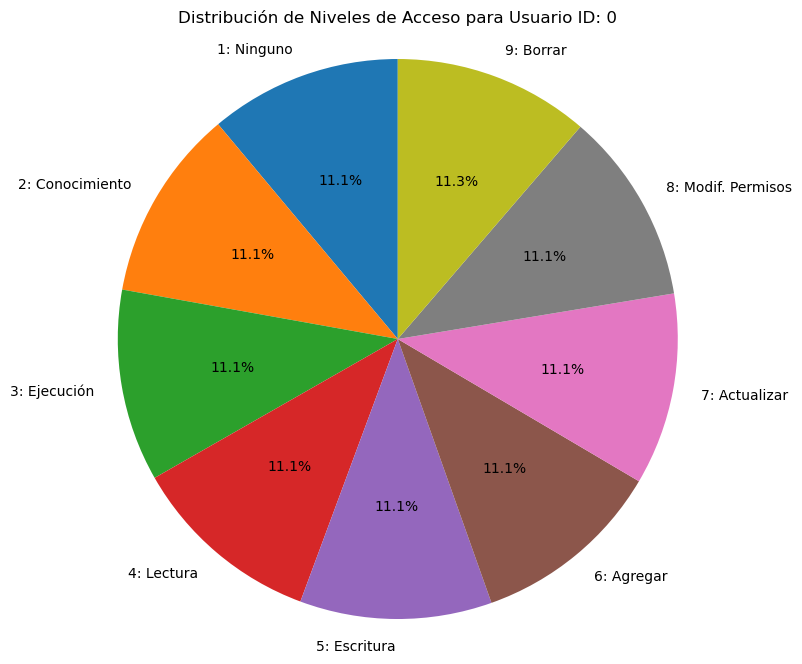

In [ ]:
# Ejemplo de uso completo del FileSystem
if __name__ == "__main__":
    print("=== INICIALIZANDO SISTEMA DE ARCHIVOS ===")
    fs = FileSystem()
    
    # print("\n=== 1. INTENTO DE LOGIN FALLIDO ===")
    # fs.iniciar_sesion("1", "password_incorrecto")
    
    # 2. Iniciar sesión correctamente
    print("\n=== 2. LOGIN EXITOSO ===")
    fs.iniciar_sesion("0", "123456789")
    
    # print("\n=== 4. MIS ARCHIVOS ===")
    # fs.listar_archivos_accesibles()
    
    # print("\n=== 5. BUSCAR ARCHIVO EXISTENTE ===")
    # fs.buscar_abrir_archivo("VivamusTortorDuis.pdf")
    # fs.buscar_abrir_archivo("PotentiNullamPorttitor.png")

    # print("\n=== 6. CREANDO NUEVO ARCHIVO ===")
    # permisos_nuevos = {"0": 9,"1": 4,"5": 2}
    # fs.crear_archivo("ReporteAnual2.txt", "Contenido Confidencial.", permisos_nuevos)
    # 8. Graficar intentos de sesión para todos los usuarios
    # print("\n=== 8. GRAFICANDO INTENTOS DE SESIÓN (TODOS) ===")
    # fs.graficar_intentos_sesion()

    # # 9. Graficar intentos de sesión para un usuario específico (ej. "0")
    # print("\n=== 9. GRAFICANDO INTENTOS DE SESIÓN (USUARIO 0) ===")
    # fs.graficar_intentos_sesion("0")
    # print("\n=== 10. GRAFICANDO NIVELES DE ACCESO (USUARIO 0) ===")
    # fs.graficar_niveles_acceso_usuario()

    fs.cerrar_sesion()